In [1]:
from keras.models import Model
from keras import backend as K
from keras.utils.image_utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from metrics import dice_loss, dice_coef, iou
import os
import cv2
import glob
import numpy as np
from PIL import Image, ImageOps
from skimage import color
from skimage import io
img = []
masks = []
IMAGE_SIZE = (256,256)

## Upload / Prepare Data

In [2]:
def training_data():
    
    img_dir = './imgDeep' #orginal directory
    mask_dir = './newMasks' #augmented directory
    data_img_path = os.path.join(img_dir,'*g')
    data_mask_path = os.path.join(mask_dir,'*g')

    img_files = glob.glob(data_img_path) #error @ rgb_img when removing glob.glob dunno y
    mask_files = glob.glob(data_mask_path)
    data = []
    
    for f1 in img_files:
        orgImg = Image.open(f1).resize(IMAGE_SIZE)
        mirImg = ImageOps.mirror(Image.open(f1).resize(IMAGE_SIZE))
        
        
        img.append(np.array(orgImg)) 
        img.append(np.array(mirImg))
        img.append(np.array(ImageOps.flip(orgImg)))
        img.append(np.array(ImageOps.flip(mirImg)))
        
    for f2 in mask_files:
        
        orgMask = Image.open(f2).resize(IMAGE_SIZE)
        mirMask = ImageOps.mirror(Image.open(f2).resize(IMAGE_SIZE))
        
        masks.append(np.array(orgMask))
        masks.append(np.array(mirMask))
        masks.append(np.array(ImageOps.flip(orgMask)))
        masks.append(np.array(ImageOps.flip(mirMask)))
        
  
training_data()

In [3]:
img_np = np.array(img)
masks_np = np.array(masks)

In [4]:
print(img_np.shape, masks_np.shape)

(400, 256, 256, 3) (400, 256, 256, 4)


In [5]:
#masks_np = np.array(masks_np/255.0)
masksCV = []
imgCV = []

for f2 in masks_np:
   masksCV.append(cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY))
    

#for f2 in img:
#    imgCV.append(Image.open(f2))

masksCV_np = np.array(masksCV)



In [6]:
print(img_np.shape, masksCV_np.shape)

(400, 256, 256, 3) (400, 256, 256)


In [7]:
print(img_np.shape, masksCV_np.shape)

(400, 256, 256, 3) (400, 256, 256)


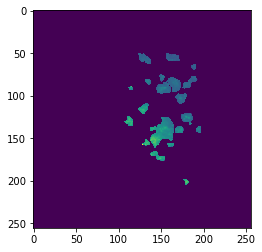

In [8]:
from matplotlib import pyplot as plt
plt.imshow(masksCV_np[0], interpolation='nearest')
plt.show()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


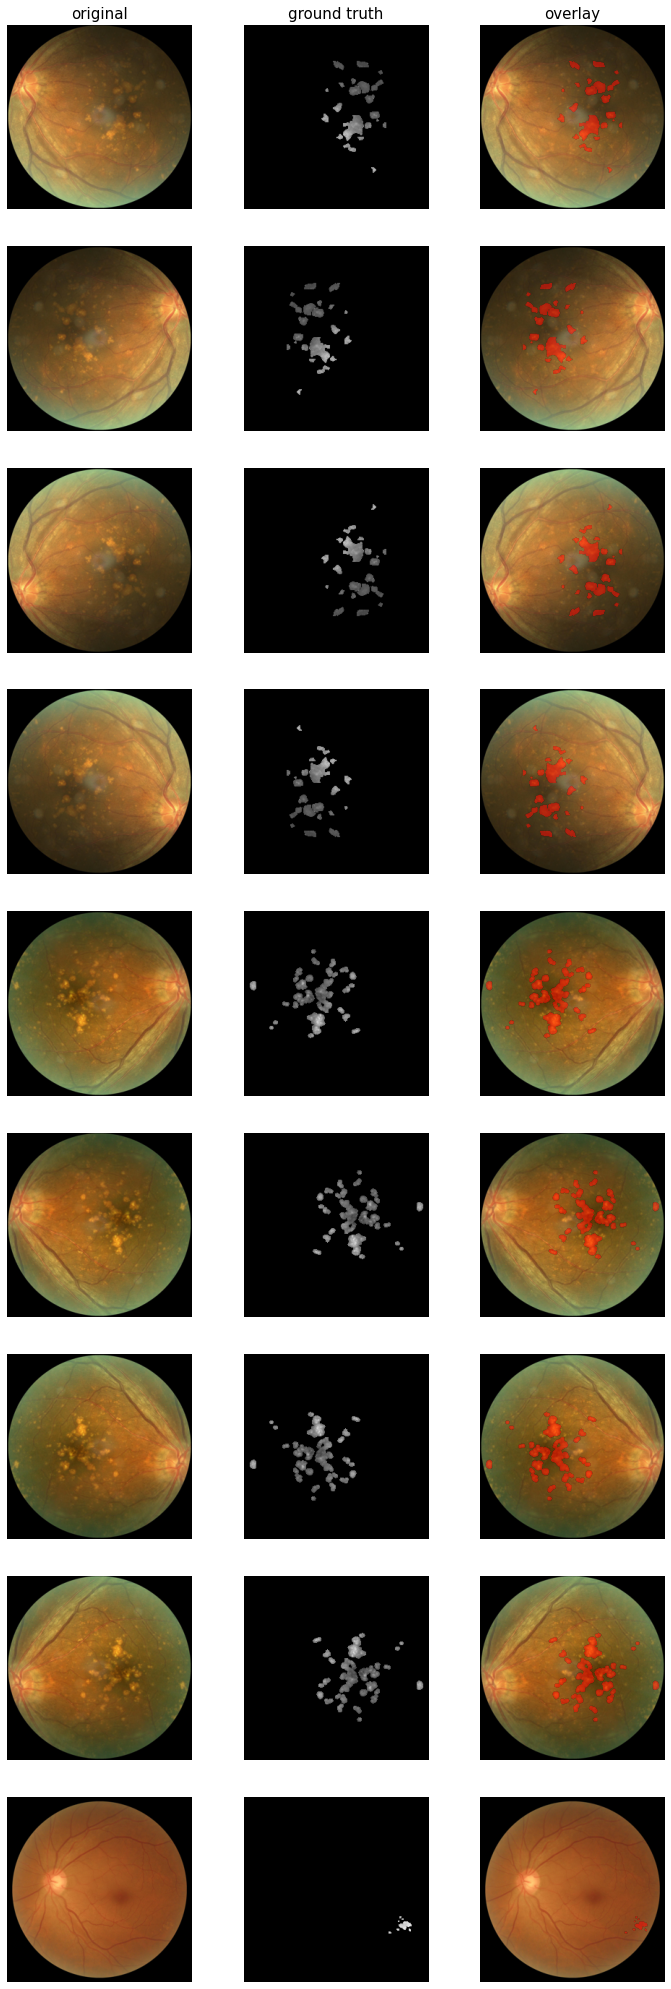

In [9]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=img_np, mask_imgs=masksCV_np, nm_img_to_plot=9, figsize=4)

In [10]:
print(img_np.max(), masksCV_np.max())

255 255


In [11]:
x = np.asarray(img_np, dtype=np.float32)/255
y = np.asarray(masksCV_np, dtype=np.float32)/255

In [12]:
print(x.max(), y.max())

1.0 1.0


In [13]:
print(x.shape, y.shape)

(400, 256, 256, 3) (400, 256, 256)


In [14]:
x[0][0][0].shape 

(3,)

In [15]:
#checks if image input is b&w
if(x[0][0][0].shape == ()):
  x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    
print(x.shape, y.shape)

(400, 256, 256, 3) (400, 256, 256, 1)


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(x, y, test_size=0.1, random_state=1)

x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_rem: ", x_rem.shape)
print("y_rem: ", y_rem.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (360, 256, 256, 3)
y_train:  (360, 256, 256, 1)
x_rem:  (40, 256, 256, 3)
y_rem:  (40, 256, 256, 1)
x_val:  (20, 256, 256, 3)
y_val:  (20, 256, 256, 1)


In [17]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("this happened")

this happened


## Deeplab Implementation

In [18]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard


DeepLab_model_filename = 'DeepLab_Model.h5'
callback_checkpoint =[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False),
ModelCheckpoint(
    DeepLab_model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-7, verbose=1),
TensorBoard()]



In [19]:
from model import deeplabv3_plus

In [20]:
deepLabModel = deeplabv3_plus(x_train[0].shape)
print(x_train[0].shape)

(256, 256, 3)


In [21]:
deepLabModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
from tensorflow import keras
loss = keras.losses.BinaryCrossentropy()
deepLabModel.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", dice_coef, iou, Recall(), Precision()],
)

In [23]:
if(os.path.exists(DeepLab_model_filename)):
    deepLabModel.load_weights(DeepLab_model_filename)

print(os.path.exists(DeepLab_model_filename))

False


In [24]:
with tf.device('GPU'):
    history = deepLabModel.fit(x=x_train, y=y_train, batch_size=4, epochs=100, validation_data=(x_val, y_val),
                           callbacks=callback_checkpoint)

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9607 - dice_coef: 0.0308 - iou: 0.0158 - recall: 0.0208 - precision: 0.0200
Epoch 1: val_loss improved from inf to 0.05236, saving model to DeepLab_Model.h5
90/90 [==============================] - 51s 410ms/step - loss: 0.0912 - accuracy: 0.9607 - dice_coef: 0.0308 - iou: 0.0158 - recall: 0.0208 - precision: 0.0200 - val_loss: 0.0524 - val_accuracy: 0.9833 - val_dice_coef: 0.0204 - val_iou: 0.0103 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9805 - dice_coef: 0.0900 - iou: 0.0479 - recall: 0.0014 - precision: 0.5313
Epoch 2: val_loss improved from 0.05236 to 0.03701, saving model to DeepLab_Model.h5
90/90 [==============================] - 37s 410ms/step - loss: 0.0298 - accuracy: 0.9805 - dice_coef: 0.0900 - iou: 0.0479 - recall: 0.0014 - precision: 0.5313 - val_loss: 0.0370 - val_accur

In [25]:
#deepLabModel.load_weights(DeepLab_model_filename)
#with tf.device('CPU'):
#    testOut = deepLabModel.evaluate(x_test, y_test, batch_size=3)

In [26]:
#deepLabModel.load_weights(DeepLab_model_filename)
with tf.device('CPU'):
    result = deepLabModel.predict(x_test)

1/1 [==============================] - 6s 6s/step


In [27]:
print(result)

[[[[4.7057131e-07]
   [4.7057131e-07]
   [4.7147645e-07]
   ...
   [7.8414348e-07]
   [7.0880805e-07]
   [7.0880805e-07]]

  [[4.7057131e-07]
   [4.7057131e-07]
   [4.7147645e-07]
   ...
   [7.8414348e-07]
   [7.0880805e-07]
   [7.0880805e-07]]

  [[1.0543815e-06]
   [1.0543815e-06]
   [1.0069438e-06]
   ...
   [1.5772772e-06]
   [1.4540598e-06]
   [1.4540598e-06]]

  ...

  [[8.4379104e-07]
   [8.4379104e-07]
   [8.6194444e-07]
   ...
   [2.9664297e-06]
   [2.7286371e-06]
   [2.7286371e-06]]

  [[5.5890780e-07]
   [5.5890780e-07]
   [5.7883352e-07]
   ...
   [2.0434886e-06]
   [1.7888661e-06]
   [1.7888661e-06]]

  [[5.5890780e-07]
   [5.5890780e-07]
   [5.7883352e-07]
   ...
   [2.0434886e-06]
   [1.7888661e-06]
   [1.7888661e-06]]]


 [[[7.5956876e-07]
   [7.5956876e-07]
   [8.6680637e-07]
   ...
   [1.1380486e-06]
   [9.8758073e-07]
   [9.8758073e-07]]

  [[7.5956876e-07]
   [7.5956876e-07]
   [8.6680637e-07]
   ...
   [1.1380486e-06]
   [9.8758073e-07]
   [9.8758073e-07]]

  [[9.4

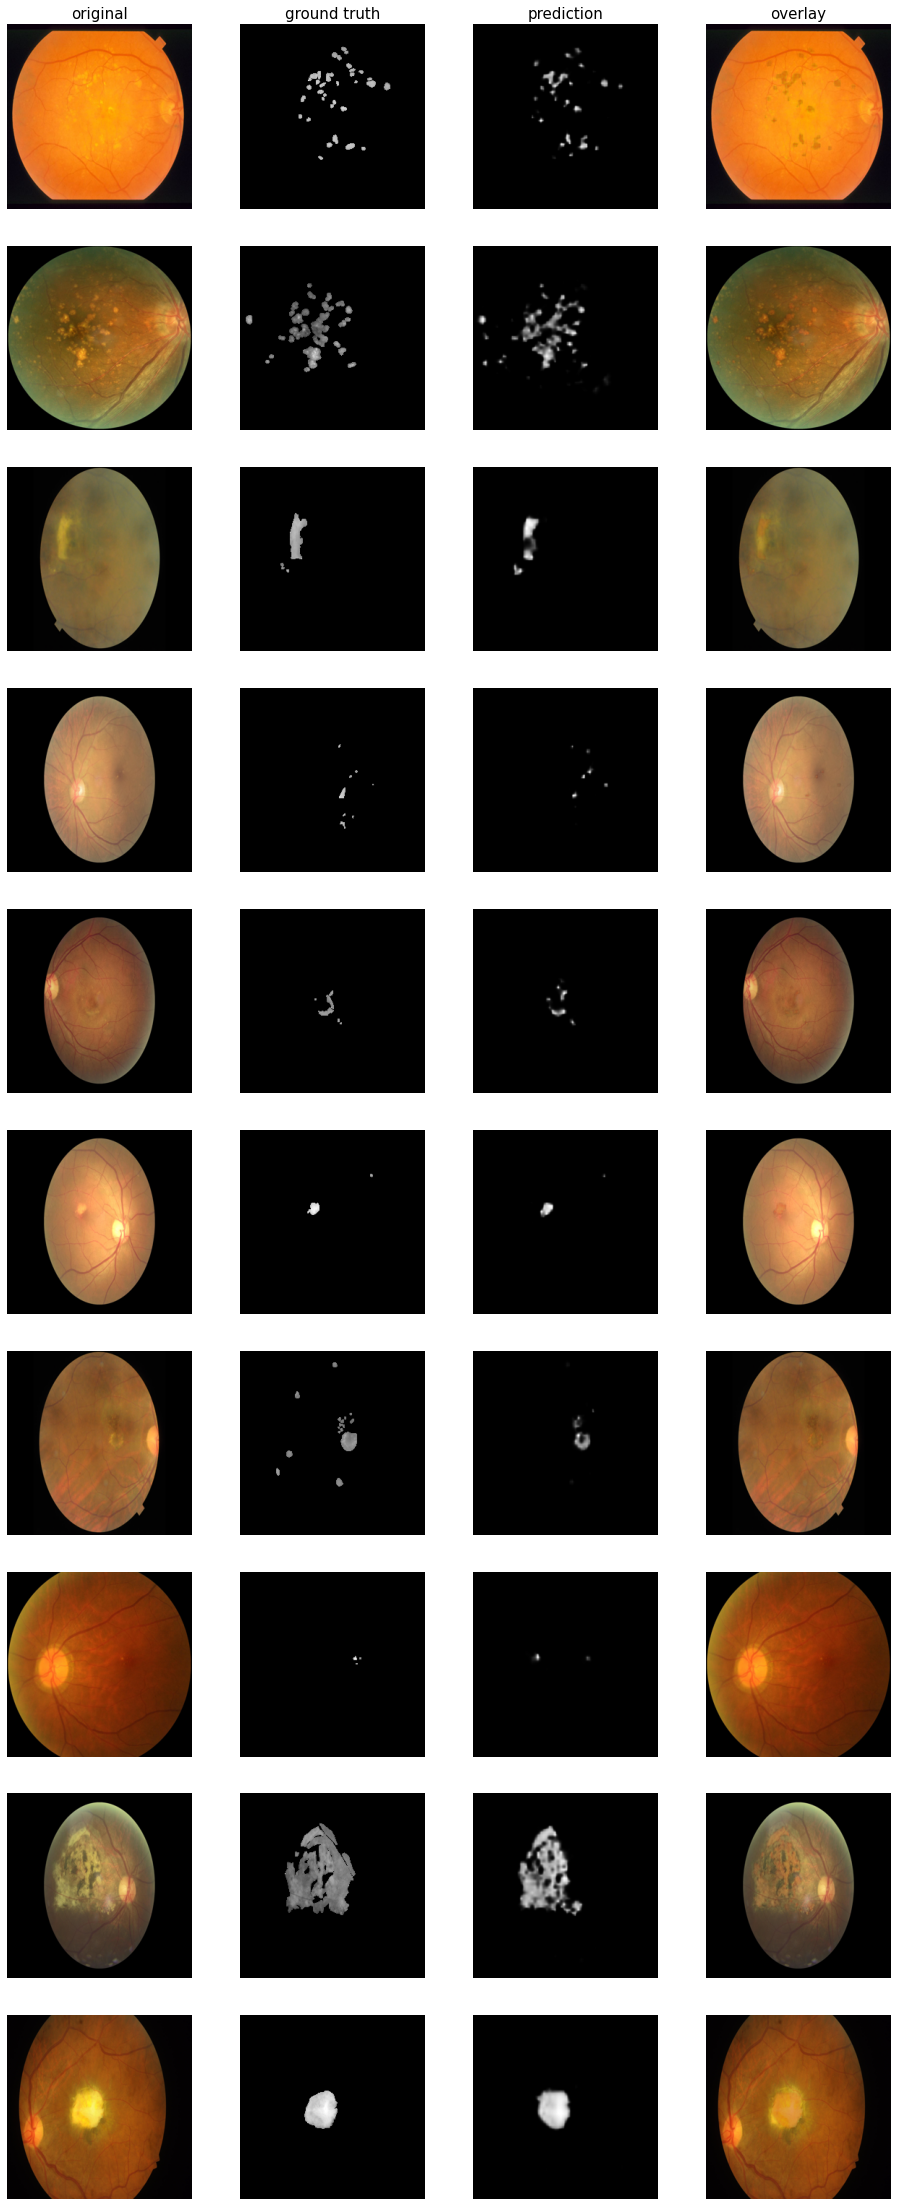

In [28]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=result, nm_img_to_plot=10)

In [40]:
singleImg = "../../data/preprocessing/filtered-data/STARE/AMD w others/im0007.jpg"
print(os.path.exists(singleImg))

if(os.path.exists(singleImg)):
    singleImgInput = np.array(Image.open(singleImg).resize(IMAGE_SIZE)) 
    singleImgInput = np.expand_dims(singleImgInput, axis=0)
    singleImgInput = np.array(singleImgInput)
    
    with tf.device('CPU'):
        singImgOut = deepLabModel.predict(singleImgInput)



True
1/1 [==============================] - 0s 191ms/step


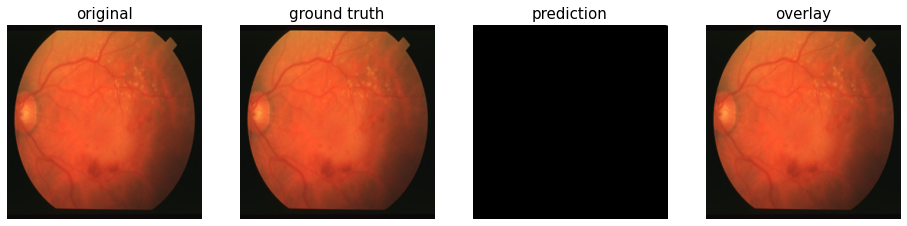

In [41]:
plot_imgs(org_imgs=singleImgInput, mask_imgs=singleImgInput, pred_imgs=singImgOut, nm_img_to_plot=10)

In [31]:
print(np.unique(singImgOut))

[0.]


## Implementation to random data

In [50]:
test_dir = './DeepLabTest' #orginal directory
data_test_path = os.path.join(test_dir,'*g')
testList = []

test_files = glob.glob(data_test_path) 

    
for f1 in test_files:
    testImg = Image.open(f1).resize(IMAGE_SIZE)      
    testList.append(np.array(testImg)) 

In [51]:
test_np = np.array(testList)

In [52]:
print(test_np.shape)

(8, 256, 256, 3)


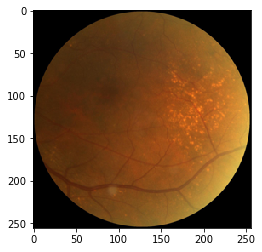

In [53]:
from matplotlib import pyplot as plt
plt.imshow(test_np[0], interpolation='nearest')
plt.show()

In [54]:
print(test_np.max())

255


In [55]:
testData = np.asarray(test_np, dtype=np.float32)/255
print(testData.max())
print(testData.shape)

1.0
(8, 256, 256, 3)


In [57]:
with tf.device("CPU"): 
    testResult = deepLabModel.predict(testData)

1/1 [==============================] - 2s 2s/step


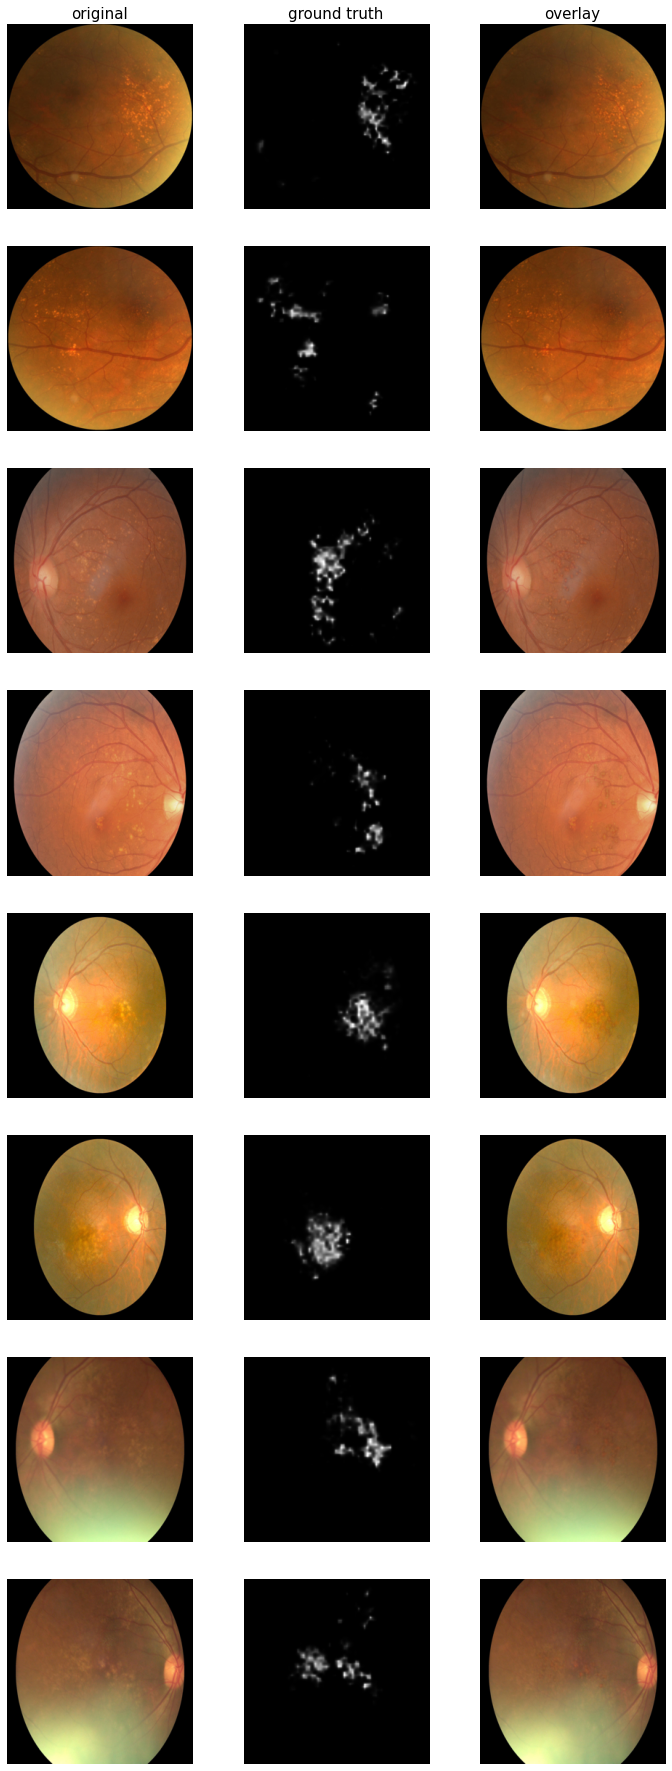

In [58]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=test_np, mask_imgs=testResult, nm_img_to_plot=8, figsize=4)

In [59]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]